# 1 - Introduction

Nama : Dicky Librata Sembiring 

Dataset : X-Ray Images of Human Lung

Objective : Memprediksi Penyakit Covid, Pneumonia Atau Normal Berdasarkan Hasil X-Ray


## Link Streamlit
https://huggingface.co/spaces/barentz96/Lung-XRay-Prediction

# 2 - Import Libraries
Berikut adalah library python yang digunakan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau


# 3 - Data Loading

## Setting GPU For Tensorflow

In [2]:
# Nvida setting for tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load Images
Setelah melakukan setting memory GPU, selanjutnya adalah loading gambar x-ray.

In [3]:
# normal x-ray
normal = keras.utils.image_dataset_from_directory('D:/Hactive8/Phase 2/Milestone/p2---ftds-003-hck--m2-librata96/Covid X-Ray/normal')

# covid x-ray
covid = keras.utils.image_dataset_from_directory('D:/Hactive8/Phase 2/Milestone/p2---ftds-003-hck--m2-librata96/Covid X-Ray/covid')

# pneumonia x-ray
pneumonia = keras.utils.image_dataset_from_directory('D:/Hactive8/Phase 2/Milestone/p2---ftds-003-hck--m2-librata96/Covid X-Ray/pneumonia')

Found 1525 files belonging to 1 classes.
Found 1525 files belonging to 1 classes.
Found 1525 files belonging to 1 classes.


Masing - masing kondisi antara `normal`, `covid`, dan `pneumonia` memiliki `1525` files gambar

## Show Images
Berikut adalah tampilan dari x-ray paru paru dengan kondisi sehat, penderita covid dan penderita pneumonia

In [4]:
# get the labels
covid_label = covid.class_names
normal_label = normal.class_names
pneumonia_label = pneumonia.class_names

### Normal X-Ray

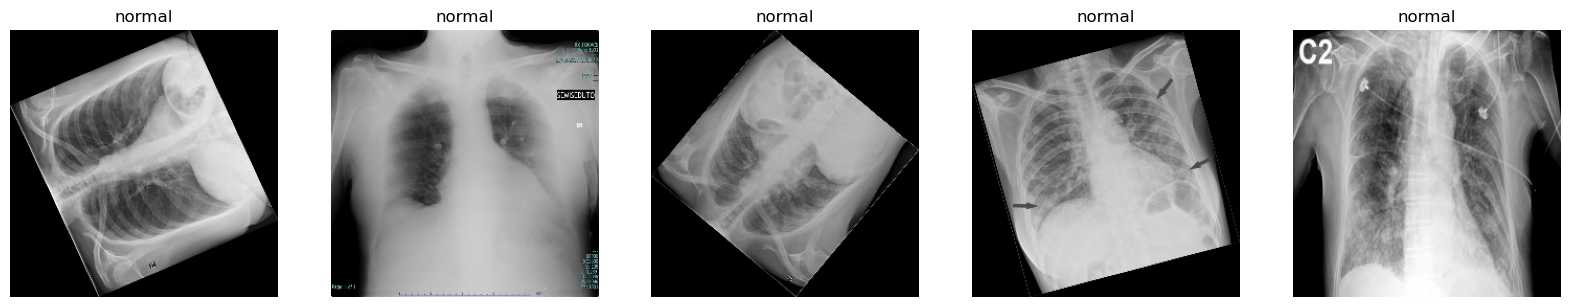

In [5]:
# normal images
plt.figure(figsize=(20, 10))
for images, labels in covid.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(normal_label[np.argmax(labels[i])])
        plt.axis("off")

### Covid X-Ray

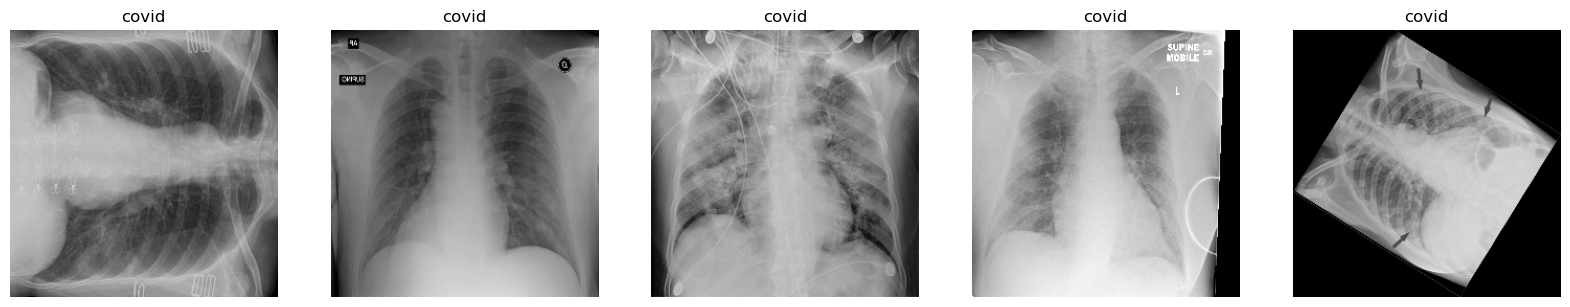

In [6]:
# covid images
plt.figure(figsize=(20, 10))
for images, labels in covid.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(covid_label[np.argmax(labels[i])])
        plt.axis("off")

### Pneumonia X-Ray

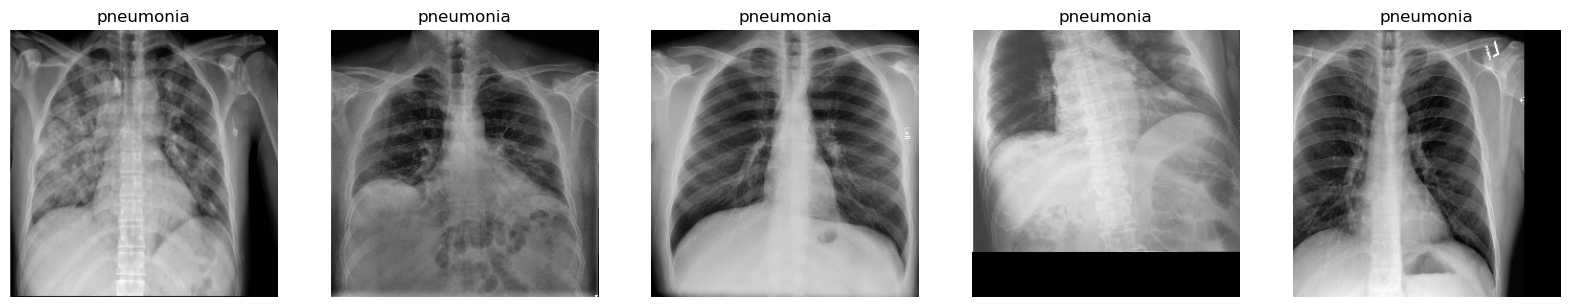

In [7]:
# pneumonia images
plt.figure(figsize=(20, 10))
for images, labels in covid.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(pneumonia_label[np.argmax(labels[i])])
        plt.axis("off")

# 4 - Exploratory Data Analysis (EDA)

Setelah loading images, penulis melakukan beberapa EDA sederhana seperti cek dimensi gambar dan cek posisi atau kondisi gambar 

In [8]:
# check images resolution
for images, labels in covid.take(1):
    print(images.shape[1:])

(256, 256, 3)


Gambar memiliki resolusi 256 x 256 x dengan 3 channel. Selanjutnya melakukan pengecekan posisi gambar untuk menentukan proses augmentasi gambar

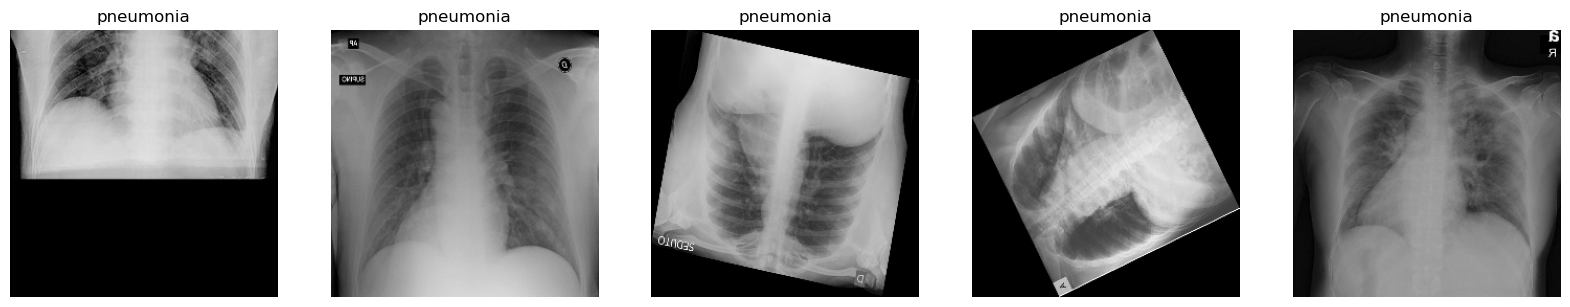

In [9]:
# show images
plt.figure(figsize=(20, 10))
for images, labels in covid.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(pneumonia_label[np.argmax(labels[i])])
        plt.axis("off")

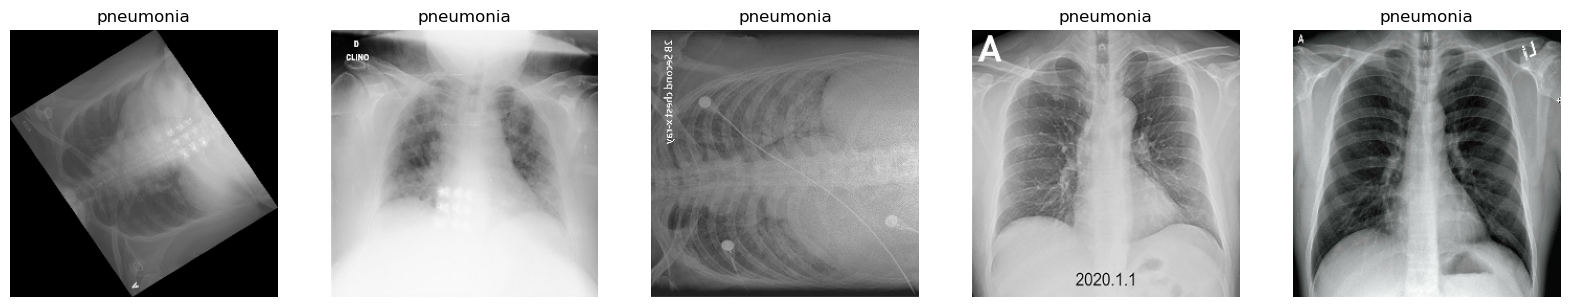

In [10]:
# show images
plt.figure(figsize=(20, 10))
for images, labels in covid.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(pneumonia_label[np.argmax(labels[i])])
        plt.axis("off")

Dari gambar di atas, posisi gambar sudah bervariasi seperti :
- Gambar Terbalik
- Gambar Crop
- Gambar Menyamping

Sehingga hanya perlu sedikit proses augmentasi

# 5 - Feature Engineering

## Split Train, Validation, And Test Dataset
Langkah awal feature engineering adalah membuat data train, data validation dan data test

In [34]:
# make train and test dataset
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'D:/Hactive8/Phase 2/Milestone/p2---ftds-003-hck--m2-librata96/Covid X-Ray',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    subset="both",
    validation_split=0.2,
    batch_size=64,
    shuffle=True,
    seed = 54
)

# get train dataset labels
train_dataset_labels = train_dataset.class_names

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Using 915 files for validation.


In [36]:
# split train dataset into train adan validation dataset
train_dataset = train_dataset.take(int(0.8* len(train_dataset)))
test_dataset = train_dataset.skip(int(0.8 * len(train_dataset)))

In [37]:
# Suffle and prefetch train and valitation dataset
train_dataset = train_dataset.cache().shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)

## Data Augmentation
Kemudian melakukan proses augmentasi pada data train.

Karena gambar awal sudah cukup bervariasi, maka penulis hanya menambah sedikit proses augmentasi agar gambar lebih variatif. Jenis augmentasinya adalah :
- Flip horizontal
- Memutar gambar sebanyak 30 derajat

Selain itu, penulis hanya memberikan sedikit augmentasi karena data gambar merupakan hasil x-ray dari seorang pasien. Dimana gambar tersebut harus tetap mempertahankan informasi aslinya. Oleh karena itu penulis hanya memberikan augmentasi berupa memutar ataupun membalik gambar secara horzontal yang mana kedua augmentasi tersebut tidak membuat informasi dari gambar berubah

In [14]:
# Make augmentation layers
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.3),
    ]
)

In [15]:
# Apply `data_augmentation` to the training images.
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Show Augmented Images

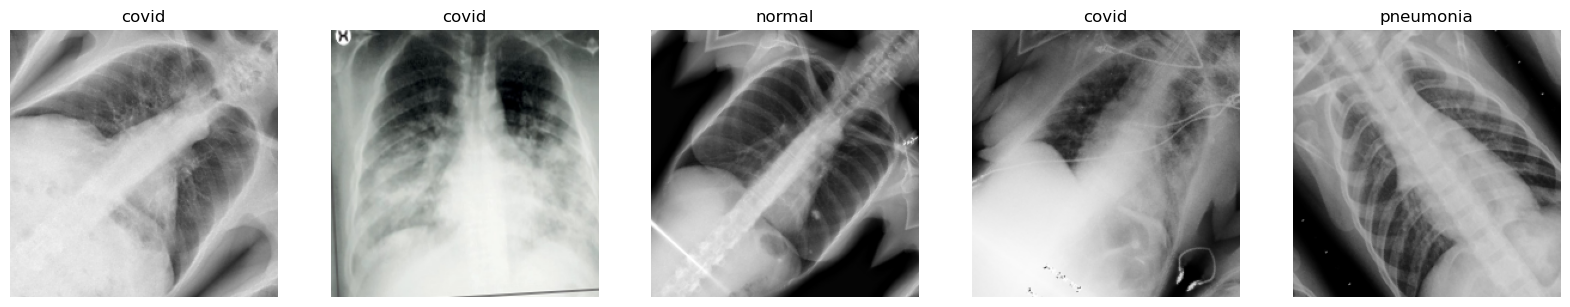

In [16]:
# augmented images
plt.figure(figsize=(20, 10))
for images, labels in train_dataset.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset_labels[np.argmax(labels[i])])
        plt.axis("off")

Gambar diatas adalah data train yang telah di lakukan proses augmentasi. Terlihat bahwa posisi gambar lebih bervariasi dibanding gambar awal

# 6 - Model Definition

## Define Architecture and Compiler
Setelah melakukan proses augmentasi, Berikutnya adalah membuat model deep learning menggunakan Convolutional Neural Network

Penulis membuat model dasar menggunakan sequential API dengan arsitektur dan komponen compiler sederhana seperti berikut 

In [17]:
# define architecture
model_awal = keras.models.Sequential()
model_awal.add(layers.Input(shape=(224, 224, 3)))
model_awal.add(layers.Rescaling(1./255.))
model_awal.add(layers.Conv2D(8, (3,3),activation='relu'))
model_awal.add(layers.MaxPooling2D(2, 2))
model_awal.add(layers.Conv2D(16, (3,3), activation='relu')) 
model_awal.add(layers.MaxPooling2D(2, 2))  
model_awal.add(layers.Conv2D(32, (3,3),activation='relu')) 
model_awal.add(layers.MaxPooling2D(2, 2))
model_awal.add(layers.Flatten())
model_awal.add(layers.Dropout(0.5))
model_awal.add(layers.Dense(16, activation='relu'))
model_awal.add(layers.Dense(3, activation='softmax'))

In [18]:
# model compiler
model_awal.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics='accuracy')

## Define Callback
Pada Artificial Neural Network perlu diberikan sebuah fungsi untuk menghentikan proses training apabila model sudah mencapai performa terbaik untuk menhindari penurunan performa model. Oleh karena itu perlu di definisikan sebuah fungsi yang memiliki kondisi tertentu agar model berhenti melakukan training

In [19]:
# define callback
cb_awal = [
EarlyStopping(monitor='val_loss', patience= 4, restore_best_weights=True),
ModelCheckpoint('model_awal.hdf5', monitor='val_loss', save_best_only=True)
]

# 7 - Model Training
Pada proses training model diberikan kesempatan belajar sebanyak `200 kali` namun dengan pembatasan sesuai dengan fungsi callback yang sudah di defenisikan sebelumnya.

In [20]:
with tf.device('/gpu:0'):
    history_awal = model_awal.fit(train_dataset, epochs=200, validation_data = val_dataset,verbose = 1, callbacks=cb_awal, workers=-1)

Epoch 1/200
46/46 [==============================] - 11s 115ms/step - loss: 0.9548 - accuracy: 0.5421 - val_loss: 0.8975 - val_accuracy: 0.4798
Epoch 2/200
46/46 [==============================] - 4s 66ms/step - loss: 0.7438 - accuracy: 0.6994 - val_loss: 0.7056 - val_accuracy: 0.7137
Epoch 3/200
46/46 [==============================] - 4s 64ms/step - loss: 0.6678 - accuracy: 0.7364 - val_loss: 0.8848 - val_accuracy: 0.5880
Epoch 4/200
46/46 [==============================] - 4s 66ms/step - loss: 0.6580 - accuracy: 0.7459 - val_loss: 0.6184 - val_accuracy: 0.7639
Epoch 5/200
46/46 [==============================] - 4s 64ms/step - loss: 0.5964 - accuracy: 0.7758 - val_loss: 0.6853 - val_accuracy: 0.7093
Epoch 6/200
46/46 [==============================] - 4s 65ms/step - loss: 0.5877 - accuracy: 0.7677 - val_loss: 0.5504 - val_accuracy: 0.7967
Epoch 7/200
46/46 [==============================] - 4s 66ms/step - loss: 0.5494 - accuracy: 0.7918 - val_loss: 0.5902 - val_accuracy: 0.7792
Epoc

# 8 - Model Evaluation
Setelah model melakukan proses training, penulis mencoba melakukan evaluasi terhadap model dengan menggunakan data history dari proses training model

## Model Summary
### Model Architecture

In [21]:
# model summary
model_awal.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)       

Model awal yang di bangun memiliki `352.211 Parameters`yang dapat berubah setiap epoch

### Model Accuracy and Loss 
Dengan menggunakan history dari proses pembelajarn mode, penulis melakukan plotting terhadap akurasi dan besaran loss dari setiap cycle pembelajaran model

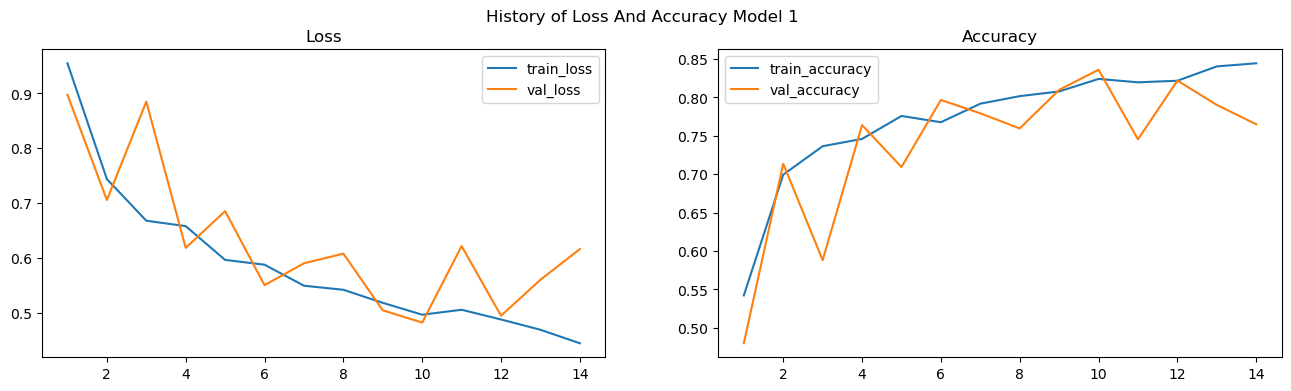

In [22]:
# define epoch
epoch_sum=len(history_awal.epoch)

# make figure
fig, ax = plt.subplots(ncols=2,figsize=(16,4))

# plot model sequential loss
ax[0].plot(range(1,epoch_sum+1),history_awal.history['loss'],label='train_loss')
ax[0].plot(range(1,epoch_sum+1),history_awal.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()

# plot model sequential accuracy
ax[1].plot(range(1,epoch_sum+1),history_awal.history['accuracy'],label='train_accuracy')
ax[1].plot(range(1,epoch_sum+1),history_awal.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

fig.suptitle('History of Loss And Accuracy Model 1')
plt.show()

Dari plot diatas, ada beberapa informasi yang dapat diambil
- Terdapat gradient exploding pada data validation
- Proses training terhenti pada epoch ke 10 karena model tidak mengalami peningkatan performa sejak epoch ke 6
- Model mengalami overfit karena memiliki performa bagus hanya pada data train

## Model Evalute on Data Test

In [23]:
# evaluate data test
train_evaluate_awal = model_awal.evaluate(train_dataset, verbose=0)
test_evaluate_awal = model_awal.evaluate(test_dataset, verbose=0)
print('-'*10, 'Evaluate First Model', '-'*10)
print(f"Data Train Loss Value :{train_evaluate_awal[0]:.4f}\nData Train Accuracy {train_evaluate_awal[1]:.4f}\n")
print(f"Data Test Loss Value :{test_evaluate_awal[0]:.4f}\nData Test Accuracy {test_evaluate_awal[1]:.4f}")


---------- Evaluate First Model ----------
Data Train Loss Value :0.4598
Data Train Accuracy 0.8322

Data Test Loss Value :0.4826
Data Test Accuracy 0.8344


Dari Hasil evaluate data test, model memiliki performa `0.8344` dan loss value `0.4826`

# 9- Model Optimization
Dari hasil evaluasi diatas, penulis mencoba melakukan beberapa optimisasi untuk mendapatkan performa yang lebih baik dari sisi nilai accuracy, waktu training, maupun, kompleksitas dari model

## Define Architecture and Compiler
Arsitektur tuned model menggunakan sequentional API. Beberapa optimisasi adalah :
- Menambah `neuron (x2)` pada masing masing convolutional layers
- Menentukan kernel iniatilizer sebagai `glorot uniform`
- Memberikan penalti dengan kernel regularizer dengan `L2` sebanyak `0.002`
- Menentukan `learning rate` awal dengan `0.001` dan `clipnorm 2.5`

In [24]:
# define model
model_tuned = keras.models.Sequential()
model_tuned.add(layers.Input(shape=(224, 224, 3)))
model_tuned.add(layers.Rescaling(1./255.))
model_tuned.add(layers.Conv2D(16, (3,3),activation='relu'))
model_tuned.add(layers.MaxPooling2D(2, 2))
model_tuned.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_uniform',kernel_regularizer=tf.keras.regularizers.L2(l2=0.002))) 
model_tuned.add(layers.MaxPooling2D(2, 2))  
model_tuned.add(layers.Conv2D(64, (3,3),activation='relu', kernel_initializer='glorot_uniform',kernel_regularizer=tf.keras.regularizers.L2(l2=0.002))) 
model_tuned.add(layers.MaxPooling2D(2, 2))  
model_tuned.add(layers.Conv2D(64, (3,3),activation='relu', kernel_initializer='glorot_uniform',kernel_regularizer=tf.keras.regularizers.L2(l2=0.002))) 
model_tuned.add(layers.MaxPooling2D(2, 2))
model_tuned.add(layers.Flatten())
model_tuned.add(layers.Dropout(0.5))
model_tuned.add(layers.Dense(16, activation='relu', kernel_initializer='glorot_uniform',kernel_regularizer=tf.keras.regularizers.L2(l2=0.002)))
model_tuned.add(layers.Dense(8, activation='relu', kernel_initializer='glorot_uniform',kernel_regularizer=tf.keras.regularizers.L2(l2=0.002)))
model_tuned.add(layers.Dense(3, activation='softmax'))

# define compiler
model_tuned.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=2.5), metrics='accuracy')

## Defince Callback
Pada fungsi callback juga diberikan optimisasi yaitu :
- Menambah patien menjadi 5
- Menambah fungsi reduceLROnPlateu 

In [25]:
# define callback
cb_tuned = [
EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True),
ModelCheckpoint('model_tuned.hdf5', monitor='val_loss', save_best_only=True),
ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, mode='auto', min_lr=0.00001)
]

## Model Training

In [26]:
with tf.device('/gpu:0'):
    history_tuned = model_tuned.fit(train_dataset, epochs=150, validation_data = val_dataset, verbose = 1, callbacks=cb_tuned, workers=-1)

Epoch 1/150
46/46 [==============================] - 8s 112ms/step - loss: 1.2223 - accuracy: 0.4558 - val_loss: 1.0824 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 2/150
46/46 [==============================] - 5s 104ms/step - loss: 0.9709 - accuracy: 0.5999 - val_loss: 0.9959 - val_accuracy: 0.5836 - lr: 0.0010
Epoch 3/150
46/46 [==============================] - 5s 104ms/step - loss: 0.8641 - accuracy: 0.6753 - val_loss: 0.9849 - val_accuracy: 0.5224 - lr: 0.0010
Epoch 4/150
46/46 [==============================] - 5s 103ms/step - loss: 0.8557 - accuracy: 0.6688 - val_loss: 0.8930 - val_accuracy: 0.6426 - lr: 0.0010
Epoch 5/150
46/46 [==============================] - 5s 103ms/step - loss: 0.8492 - accuracy: 0.6766 - val_loss: 0.8754 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 6/150
46/46 [==============================] - 5s 104ms/step - loss: 0.8100 - accuracy: 0.7065 - val_loss: 0.8716 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 7/150
46/46 [==============================] - 5s 104ms/st

## Model Summary

In [30]:
model_tuned.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)       

Model yang telah dioptimasi yang di bangun memiliki `208.147 Parameters`yang dapat berubah setiap epoch

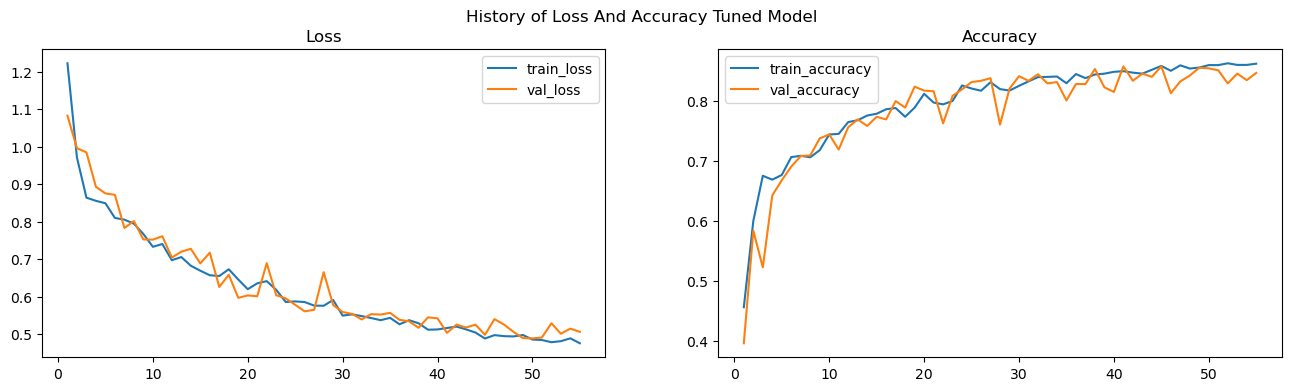

In [28]:
# define epoch
epoch_tuned=len(history_tuned.epoch)

# make figure
fig, ax = plt.subplots(ncols=2,figsize=(16,4))

# plot model sequential loss
ax[0].plot(range(1,epoch_tuned+1),history_tuned.history['loss'],label='train_loss')
ax[0].plot(range(1,epoch_tuned+1),history_tuned.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()

# plot model sequential accuracy
ax[1].plot(range(1,epoch_tuned+1),history_tuned.history['accuracy'],label='train_accuracy')
ax[1].plot(range(1,epoch_tuned+1),history_tuned.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

fig.suptitle('History of Loss And Accuracy Tuned Model')
plt.show()

Dari plot diatas, ada beberapa informasi yang dapat diambil
- Masih terdapat gradient exploding pada data validation
- Proses training terhenti pada epoch ke 56 karena model tidak mengalami peningkatan performa sejak epoch ke 51
- Model sudah cukup bestfit karena memiliki performa baik pada pada data train dan data  validation

## Model Evaluate On Data Test

In [29]:
# evaluate on data test
train_evaluate = model_tuned.evaluate(train_dataset, verbose=0)
test_evaluate = model_tuned.evaluate(test_dataset, verbose=0)
print('-'*10, 'Evaluate Tuned Model', '-'*10)
print(f"Data Train Loss Value :{train_evaluate[0]:.4f}\nData Train Accuracy {train_evaluate[1]:.4f}\n")
print(f"Data Test Loss Value :{test_evaluate[0]:.4f}\nData Test Accuracy {test_evaluate[1]:.4f}")


---------- Evaluate Tuned Model ----------
Data Train Loss Value :0.4613
Data Train Accuracy 0.8696

Data Test Loss Value :0.4659
Data Test Accuracy 0.8766


## Optimization Conclusion

Beberapa kesimpulan dari proses optimisasi model adalah sebagai berikut :
- Secara global dapat di ambil kesimpulan bahwa model mengalami peningkatan dari segi performa pada data test dari `0.83` menjadi `0.87`
- Jumlah total parameter berkurang dari `352.211` menjadi `208.147`
- Karena jumlah parameter berkurang, maka size dari model juga berkurang dari `4182 Kb` menjadi `2510 Kb`
- Masih terdapat gradient exploading meski tidak seburuk model awal

# 10 - Model Saving

Karena proses traing menggunakan fungsi callback dan terdapat parameter untuk menyimpan model, Maka tidak dilakukan kembali prose save model.

Model yang disave oleh fungsi callback merupakan model terbaik.

# 11 - Pengambilan Kesimpulan
## Model Analysis

Beberapa analisa dari model :
- Sebelum dan setelah optimisasi model memiliki performa yang cukup baik dengan accuracy pada data test `0.83`
- Namun setelah optimisasi performa model sedikit lebih baik menjadi `0.87` dan menjadi best model untuk digunakan pada model deployment.
- Best model memiliki informasi sbb:
    - Jumlah parameter `208.147`
    - Input layar `224, 224, 3` sesuai dengan dimensi foto
    - Menggunakan kernel initializer `glorot uniform`
    - Terdapat kernel regularizer berupa `l2 dengan bobot 0.002`
    - Fungsi aktivasi
        - Input layer dan hidden layer adalah fungsi aktivasi `relu`
        - Output layer karena merupakan prediksi binary maka menggunakan fungsi aktivasi `softmax`

### Kelebihan dan Kelamahan Model : 
- Kelebihan :
    - Secara global model cukup baik memprediksi dengan accuracy `0.87`
    - Model memiliki performa yang sama antara data train dan data test dengan kata lain memiliki predikat `good fit`
- Kelemahan : 
    - Masih terdapat gradient exploading

### Further Improvement
Untuk imporvement selanjutnya dari model ini adalah sbb :
- Pada saat dataset loading dengan tensorflow dilakukan proses yang lebih beragam antara shuffle, repeat, atau batch size.
- Melakukan architecture tuning dengan kombinasi jumlah layer, jumlah neuron, dan paramaeter lainnya yang lebih beragam agar mendapatkan model dengan performa lebih baik
- Menggunakan pretrained model


## Overall Analysis
### Secara keseluruhan proses yang dilakukan pada project ini adalah:

- Import semua library yang di butuhkan
- Load gambar untuk masing masing kondisi paru paru
- Exploratory Data Analysis seperti melihat bentuk dan kondisi gambar yang akan di pakai dalam model training
- Cek resolusi dari gambar
- Dataset Loading dengan Tensorflow
- Split train, validation dan test dataset
- Feature Engineering berupa proses augementasi gambar pada data train
- Model Defenition and Training
    - Define Architecture dan compiler
- Evaluasi model dengan menggunakan summary dari model dan juga history training. Kemudian menentukan optimisasi apa yang dapat dilakukan agar model memiliki performa lebih baik
- Tuning dengan mencoba beberapa kombinasi arsitektur dan optimizer 
- Saving best model dari baseline model atau model yang sudah di tuning
